# Classifying Breeds of Dogs and Cats

In [1]:
%pip install -Uqq fastbook
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import fastbook
from fastbook import *
import os
from pathlib import *
from fastai.vision.all import *

Note: you may need to restart the kernel to use updated packages.


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# import data 
path = untar_data(URLs.PETS)


In [3]:
Path.BASE_PATH = path
path.ls()

(#2) [Path('images'),Path('annotations')]

In [4]:
(path/"images").ls()

(#7393) [Path('images/beagle_115.jpg'),Path('images/boxer_18.jpg'),Path('images/Maine_Coon_157.jpg'),Path('images/scottish_terrier_28.jpg'),Path('images/english_setter_6.jpg'),Path('images/american_pit_bull_terrier_79.jpg'),Path('images/boxer_128.jpg'),Path('images/Persian_265.jpg'),Path('images/Maine_Coon_182.jpg'),Path('images/keeshond_89.jpg')...]

## Review of Regular Expressions

In [5]:
import re
str = 'an example word:cat!!!'
match = re.search(r'word:\w\w\w', str)
if match:
    print('found', match.group())
else:
    print('did not find')

found word:cat


In [6]:
# extract email from a string
str = 'Purple alice-b@google.com monkey dishwasher.'
ptr = r'[\w.-]+@[\w.-]+'

match = re.search(ptr, str)
if match:
    print(match.group())

alice-b@google.com


In [7]:
str = 'blah blah alice@google.com blah blah 123 bob@abc.com blah blue red'
ptr = r'([\w.-]+)@[\w.-]+'

emails = re.findall(ptr, str)
print(emails)

['alice', 'bob']


In [8]:
# substitution 
string = 'blah blah alice@google.com blah blah 123 bob@abc.com blah blue red'
ptr = r'([\w.-]+)@[\w.-]+'
repl = r'\1@yo-yodyne.com'
new_string = re.sub(ptr, repl, string)

print(f'string = {string}')
print(f'new_string = {new_string}')

string = blah blah alice@google.com blah blah 123 bob@abc.com blah blue red
new_string = blah blah alice@yo-yodyne.com blah blah 123 bob@yo-yodyne.com blah blue red


## Back to Pet Breeds

In [9]:
# searching for regex to match pet breads
fname = (path/"images").ls()[2]
fname.name

'Maine_Coon_157.jpg'

In [10]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['Maine_Coon']

In [11]:
# creating the data loaders 
pets = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

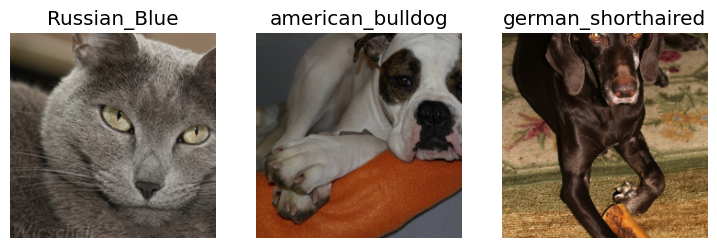

In [12]:
dls.show_batch(nrows=1, ncols=3)

In [13]:
# training
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 151MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,1.520990,0.379563,0.121786,01:12


epoch,train_loss,valid_loss,error_rate,time
0,0.498955,0.314474,0.098782,01:28
1,0.314482,0.232588,0.071042,01:27


## Cross Entropy Loss

In this example, our model's "loss" function is the cross entropy loss which is good for 2 reaason: 
- leads to faster, more reliable training
- works well when the dependent variable has more than 2 options 

In [14]:
# get one batch from training data
x,y = dls.one_batch()

In [15]:
y

TensorCategory([27,  9,  8,  6,  2, 27,  9, 28, 26, 18, 19, 17, 12,  3, 21,  5, 20, 29, 22, 26, 15, 33,  8, 22, 25, 24, 11,  4, 21, 24, 21,  6, 22, 29,  7, 35, 16, 16,  1,  3, 25, 22,  7,  9, 29, 26,
                26, 30,  0, 29, 16,  1,  0, 18, 18, 36, 26, 18, 36, 35, 18, 28, 11,  9], device='cuda:0')

In [16]:
preds,_ = learn.get_preds(dl=[(x,y)])

In [17]:
preds[0]

tensor([6.0388e-11, 1.7631e-11, 8.9121e-09, 5.8983e-10, 4.5239e-08, 9.7887e-10, 5.0643e-08, 2.4137e-08, 2.0428e-10, 1.1391e-09, 1.2759e-10, 2.2527e-10, 6.1754e-10, 6.7806e-10, 1.5200e-08, 3.9455e-10,
        5.1746e-10, 2.7736e-10, 2.8948e-08, 1.7694e-11, 1.4993e-08, 1.1240e-06, 2.1815e-07, 1.3465e-07, 2.5785e-08, 4.2721e-06, 1.7943e-09, 9.9999e-01, 3.3673e-08, 6.5788e-10, 2.9520e-08, 1.6319e-09,
        2.4237e-09, 2.5959e-10, 4.9745e-10, 8.2498e-09, 1.9950e-10])

In [18]:
len(preds[0]), preds[0].sum()

(37, tensor(1.0000))

Cross entropy is composed of log likelihood and softmax function as metrics returns values between 1 and 0 for each category, and the sum of those values is 1

In [19]:
def softmax(x): return torch.exp(x) / torch.exp(x).sum(dim=1, keepdim=True)

In [20]:
acts = torch.randn((6,2)) * 2
sm_acts = softmax(acts)
sm_acts

tensor([[0.7795, 0.2205],
        [0.8902, 0.1098],
        [0.1517, 0.8483],
        [0.5245, 0.4755],
        [0.9956, 0.0044],
        [0.8464, 0.1536]])

In [21]:
# or use pytorch
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.7795, 0.2205],
        [0.8902, 0.1098],
        [0.1517, 0.8483],
        [0.5245, 0.4755],
        [0.9956, 0.0044],
        [0.8464, 0.1536]])

## Taking the negative log of the correct label gives the cross entropy loss

In [22]:
targ = tensor([0, 1, 0, 1, 1, 1]) 
nn.CrossEntropyLoss(reduction='none')(acts,targ)

tensor([0.2491, 2.2091, 1.8857, 0.7434, 5.4201, 1.8735])

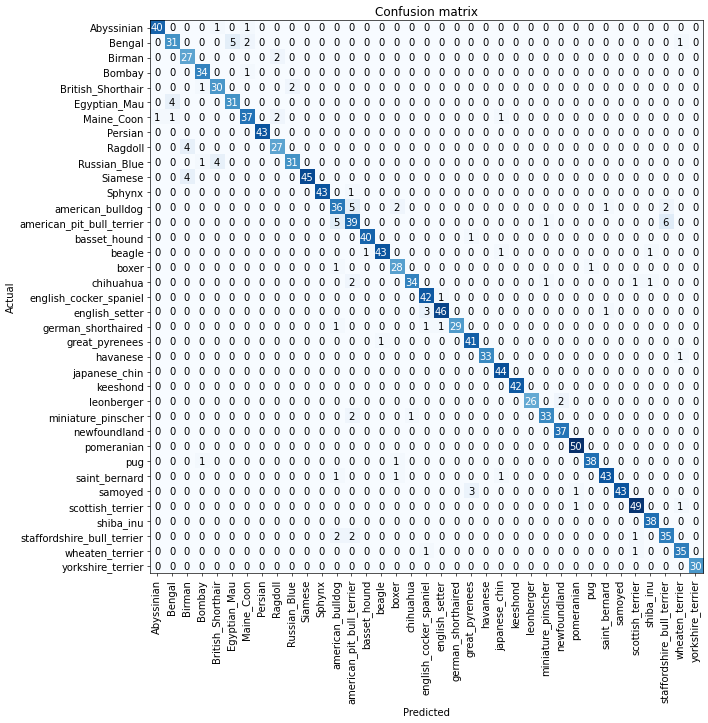

In [23]:
# losses are for computer to optimize the neural net parameters. Metrics help us humans gauge performance
interp =  ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

In [24]:
interp.most_confused(min_val=5)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('american_bulldog', 'american_pit_bull_terrier', 5),
 ('american_pit_bull_terrier', 'american_bulldog', 5)]

SuggestedLRs(valley=3.630780702224001e-05)

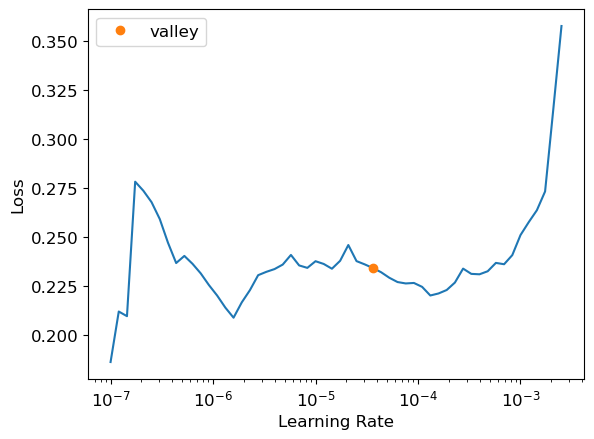

In [25]:
# use the learning rate finder to optimal learning rate 
learn.lr_find()

In [30]:
'''
Use discriminative learning rates to train a pretrained model. 
Earlier layers will have lover learning rates than latter layers
'''
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.107590,0.344232,0.102165,01:23
1,0.522081,0.251778,0.087280,01:26
2,0.319860,0.226357,0.079161,01:26


epoch,train_loss,valid_loss,error_rate,time
0,0.264440,0.221613,0.077131,01:27
1,0.266234,0.214557,0.071719,01:28
2,0.229942,0.203154,0.068336,01:28
3,0.221777,0.211658,0.073072,01:27
4,0.202905,0.206080,0.067659,01:27
5,0.181968,0.196077,0.066982,01:29
6,0.155104,0.194095,0.061570,01:31
7,0.144948,0.195003,0.062923,01:27
8,0.138524,0.190095,0.062246,01:28
9,0.128166,0.191654,0.064276,01:26


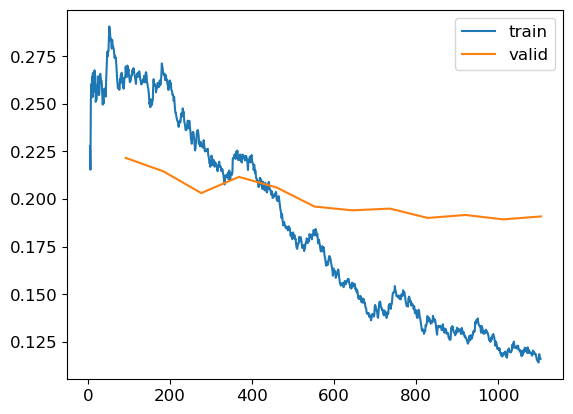

In [31]:
learn.recorder.plot_loss()

## We managed to reduce the training loss dramatically but have not overfitted the model as both the validation loss and metrics have not steadily increased.